# 승촌보 데이터 분석 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

**필수 모듈 임포트**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

**훈련 모델 준비**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

**matplotlib 한글 설정**

In [3]:
# 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 데이터 불러오기

### 수질 데이터 불러오기

**보 이름**

In [4]:
reservoir = 'Seungchonbo'

**데이터 저장소**

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

**시간 단위로 측정된 승촌보 연도별 수질 데이터 불러오기**

In [6]:
# '측정일/월' 특성은 date time으로 파싱.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

data_file = reservoir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

**시간 특성을 "년-월-일 시" 형식으로 변환하는 함수**

In [7]:
# 연도별로 별도로 작동한다.

def time2datetime(df_yearly_dict, feature):
    for year in list(df_yearly_dict.keys()):
        df_yearly_dict[year][feature] = df_yearly_dict[year][feature].apply(lambda x : x.strftime('%Y-%m-%d %H'))
    
    return df_yearly_dict

`'측정일/월'` 특성을 '년-월-일 시'형식으로 변경한다.

In [8]:
scb_yearly = time2datetime(scb_yearly, '측정일/월')

**2012년도 데이터를 제외한 모든 데이터 통합 함수**

In [9]:
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

**연도별 수질 데이터 통합**

In [10]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

# 인덱스 재설정
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

### 유량 데이터 불러오기

**10분 단위로 측정된 승촌보 연도별 유량 데이터 불러오기**

In [11]:
# `시간` 특성은 date time으로 파싱해서 불러온다.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

flow_data_file = reservoir+"_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`시간` 특성을 '년-월-일 시' 형식으로 변경한다. 

In [12]:
scb_flow_yearly = time2datetime(scb_flow_yearly, '시간')

**10분 단위를 1시간 단위로 변경**

시간별 평균값을 활용한다.

In [13]:
scb_flow_yearly_hour = {}

# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
for year in list(scb_flow_yearly.keys()):
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간', as_index=False).mean()

**연도별 유량 데이터 통합**

In [14]:
# 2013년부터 통합
scb_flow_yearly_hour_df = concat_yearly_df(scb_flow_yearly_hour)

# 인덱스 재설정
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

### 수질/유량 데이터 합병

수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.

In [15]:
# 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

# 유량 데이터 2022년도 데이터를 더 많이 포함하기에 삭제 필요.
scb_data = scb_data[:len(scb_yearly_df13)]

# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 데이터셋 전처리

**특성 선택**

모델 훈련에 사용하지 않을 특성들은 삭제한다.

In [16]:
to_be_removed = ['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)']

scb_data.drop(to_be_removed, axis=1, inplace=True)

남은 특성은 다음과 같다.

In [17]:
list(scb_data.columns)

['시간',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

## 클로로필-a와 기타 특성과의 관계

클로로필-a 수치와 녹조발생 주의보/경보 발령을 기준으로 사용하여 다른 특성들의 수치 변화를 살펴본다.

| 구분 |클로로필-a (mg/m3) |
| :---: | :---: |
| 주의보 | 15 |
| 경보 | 25 |
| 대발생 | 100 |

먼저 데이터셋을 복제해서 원본은 유지한다.

In [24]:
scb_df = scb_data.copy()

In [25]:
scb_df.columns

Index(['시간', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

### 1시간 단위로 정리된 데이터를 1일 단위로 변경

모든 특성의 일별 평균값을 이용한다.

In [26]:
scb_df['시간'] = scb_df['시간'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H').strftime('%Y-%m-%d'))

In [27]:
# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
scb_df_daily = scb_df.groupby('시간', as_index=False).mean()

scb_df_daily

,시간,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
0,2013-01-01,4.113043,406.391304,2.791667,NaN,NaN,7.025000,7.490903,18.733472
1,2013-01-02,4.282609,431.260870,2.839130,NaN,NaN,7.056522,7.501458,18.929167
2,2013-01-03,3.830435,416.565217,3.058333,NaN,NaN,7.195833,7.499236,16.621250
3,2013-01-04,3.313043,402.000000,2.730435,NaN,NaN,7.126087,7.489722,15.805556
4,2013-01-05,3.165217,409.304348,2.800000,NaN,NaN,7.220833,7.494722,13.062361
...,...,...,...,...,...,...,...,...,...
3425,2022-05-19,21.933333,477.380952,6.066667,7.954952,0.096714,48.766667,5.422292,6.935208
3426,2022-05-20,22.391304,469.434783,6.323810,7.994000,0.094545,54.026087,5.483750,8.437014
3427,2022-05-21,23.054167,460.041667,6.162500,7.449708,0.107333,56.941667,5.530972,12.939444
3428,2022-05-22,24.270833,459.000000,6.020833,7.154875,0.092583,53.133333,5.459792,10.072014


## 클로로필-a 과 녹조경보 연관성 조사

**클로로필-a: 15 이상 2주동안 지속되는 경우**

In [28]:
mask15 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 15

scb_df_daily[mask15].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,1440.000000,1440.000000,1316.000000,1395.000000,1391.000000,1445.000000,1445.000000,1445.000000
mean,17.344083,368.767635,4.617135,5.800716,0.113522,65.327176,6.756246,18.339211
std,7.725484,73.387936,0.938584,1.996815,0.061915,32.482058,0.856470,25.034152
min,3.154167,150.708333,1.980000,1.019625,0.007583,15.008333,4.799236,0.000000
25%,9.916250,312.146739,3.957292,4.363167,0.072354,38.920833,5.981389,10.386806
50%,17.030072,369.518640,4.537500,5.748792,0.100500,61.258333,7.390347,13.310347
75%,24.372733,427.147727,5.190683,7.204708,0.138504,86.825000,7.511736,19.424792
max,33.571429,599.333333,8.536842,12.105417,0.601174,216.895238,7.704097,527.370694


**클로로필-a: 25 이상 2주동안 지속되는 경우**

In [30]:
mask25 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 25

scb_df_daily[mask25].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,984.000000,984.000000,918.000000,954.000000,946.000000,988.000000,988.000000,988.000000
mean,16.363852,378.136313,4.625165,5.979717,0.111937,73.168973,6.621113,17.021399
std,8.049048,73.616102,0.908443,2.149805,0.063883,30.368973,0.851656,22.205000
min,3.154167,150.708333,2.737500,1.019625,0.007583,25.070833,5.337917,0.000000
25%,8.998201,322.020833,4.004212,4.385604,0.070302,48.447431,5.966806,9.749427
50%,15.306250,384.496212,4.491667,5.958792,0.097957,70.743750,6.040590,12.640833
75%,23.918845,439.835227,5.156399,7.610850,0.136988,92.559375,7.505712,18.554219
max,33.571429,559.000000,8.536842,12.105417,0.601174,184.663158,7.671319,527.370694


**클로로필-a: 50 이상 2주동안 지속되는 경우**

In [31]:
mask50 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 50

scb_df_daily[mask50].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,295.000000,295.000000,273.000000,284.000000,280.000000,299.000000,299.000000,299.000000
mean,14.411360,400.709529,5.004242,6.654920,0.101800,98.168148,6.218915,13.278674
std,7.919687,54.748235,0.878793,2.189976,0.049811,26.636481,0.720535,11.941054
min,4.733333,243.500000,3.150000,2.337600,0.015875,52.078261,5.337917,0.000000
25%,7.585417,361.038949,4.356250,4.906134,0.069344,77.412500,5.953819,8.597708
50%,12.578571,413.333333,4.870000,6.576729,0.093354,94.562500,5.990139,10.939236
75%,18.408333,443.895833,5.479167,8.520579,0.117781,117.080616,6.026701,13.580000
max,32.926087,526.739130,7.691304,11.166100,0.390529,184.663158,7.671319,154.341389


시기 확인

In [32]:
scb_df_daily[mask50]

,시간,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
225,2013-08-14,32.663636,269.863636,4.100000,2.962625,0.060667,67.104545,7.577639,15.610556
226,2013-08-15,32.686957,280.869565,4.579167,3.124458,0.065708,70.941667,7.580000,16.280000
227,2013-08-16,32.526087,291.826087,4.139130,3.375625,0.062833,78.878261,7.580000,16.280000
228,2013-08-17,32.213043,305.652174,4.325000,3.472250,0.093667,79.320833,7.583681,17.330625
229,2013-08-18,32.641667,310.958333,4.204167,3.231083,0.109917,82.475000,7.593264,20.071458
...,...,...,...,...,...,...,...,...,...
3345,2022-02-28,8.965217,435.043478,5.991304,9.401286,0.086952,122.778261,5.953472,6.833333
3346,2022-03-01,9.787500,444.083333,5.991667,NaN,0.078167,119.037500,5.984931,11.018819
3347,2022-03-02,9.736364,449.636364,6.077778,NaN,NaN,117.491667,5.960903,8.955486
3389,2022-04-13,21.470833,380.916667,4.837500,NaN,0.081000,78.575000,5.456250,10.418472


**클로로필-a: 100 이상 2주동안 지속되는 경우**

In [33]:
mask100 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 100

scb_df_daily[mask100].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,15.000000,15.000000,14.000000,12.000000,14.000000,15.000000,15.000000,15.000000
mean,7.643970,449.625154,5.595887,10.217116,0.104333,124.862947,5.963903,9.191514
std,1.122911,8.215614,0.534616,0.510460,0.011908,12.234088,0.008860,1.582074
min,6.452174,435.043478,4.875000,9.401286,0.078167,102.059091,5.952986,6.059722
25%,6.790119,443.723485,5.101875,10.026146,0.100462,118.264583,5.958542,8.431493
50%,7.304348,450.250000,5.653152,10.207185,0.105729,122.778261,5.961597,8.917014
75%,8.227083,455.096014,6.083194,10.498991,0.111625,132.651705,5.966806,11.004965
max,9.787500,462.125000,6.275000,11.166100,0.121042,143.304348,5.984931,11.048403


시기 확인

In [34]:
scb_df_daily[mask100]

,시간,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
3333,2022-02-16,8.083333,452.375000,4.991667,10.063625,0.112500,131.812500,5.959931,8.890486
3334,2022-02-17,7.325000,455.583333,5.137500,10.086625,0.117875,141.195833,5.964792,8.849236
3335,2022-02-18,7.304348,454.608696,5.315000,10.179952,0.109000,142.256522,5.966250,11.048403
3336,2022-02-19,7.062500,455.583333,5.166667,10.702762,0.103542,127.221739,5.956042,8.107431
3337,2022-02-20,6.458333,462.125000,5.075000,10.674091,0.105458,107.775000,5.977847,10.995069
3338,2022-02-21,6.745455,461.636364,5.090000,10.234417,0.106000,102.059091,5.959514,8.917014
3339,2022-02-22,6.834783,452.304348,4.875000,NaN,0.104500,113.804167,5.967361,11.014861
3340,2022-02-23,6.650000,450.250000,NaN,11.166100,0.115000,127.666667,5.957569,6.059722
3341,2022-02-24,6.452174,449.826087,6.275000,10.335700,0.121042,143.304348,5.963403,8.747569
3342,2022-02-25,7.054545,443.363636,6.085000,9.406500,0.108810,133.490909,5.952986,8.115417


### 클로로필-a 기준에 따른 특성들의 변화

In [56]:
mask100 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 100

desc = scb_df_daily[mask100].describe()
mean = desc.loc['mean']
df = dict()
df[100] = mean
df[20] = mean


In [58]:
pd.DataFrame(df).T

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
100,7.64397,449.625154,5.595887,10.217116,0.104333,124.862947,5.963903,9.191514
20,7.64397,449.625154,5.595887,10.217116,0.104333,124.862947,5.963903,9.191514


In [63]:
period = 14 # days

day_mean_dict = dict()

for value in range(5, 101, 5):
    mask = scb_df_daily['클로로필-a mg/㎥'].rolling(window=period).min() >= value
    desc = scb_df_daily[mask].describe()
    day_mean = desc.loc['mean']
    day_mean_dict[value] = day_mean

day_mean_df = pd.DataFrame(day_mean_dict).T

In [64]:
day_mean_df

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
5,17.901754,348.325839,4.469686,5.504168,0.119042,54.501354,6.896942,22.951752
10,17.947631,359.108073,4.609367,5.636355,0.118780,60.652470,6.801618,20.076340
15,17.344083,368.767635,4.617135,5.800716,0.113522,65.327176,6.756246,18.339211
20,16.789464,377.187009,4.640582,5.920785,0.111822,69.321608,6.678750,16.969273
25,16.363852,378.136313,4.625165,5.979717,0.111937,73.168973,6.621113,17.021399
30,16.030472,380.085213,4.638945,6.087446,0.109077,79.753048,6.505022,16.651541
35,16.361083,375.878402,4.657112,6.100338,0.105522,85.207885,6.474581,16.353601
40,15.767567,383.022720,4.675775,6.337922,0.102628,88.954035,6.404192,15.328770
45,15.281365,390.776062,4.746682,6.506485,0.099711,92.275939,6.335273,14.765307
50,14.411360,400.709529,5.004242,6.654920,0.101800,98.168148,6.218915,13.278674


In [69]:
day_mean_df.columns

Index(['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

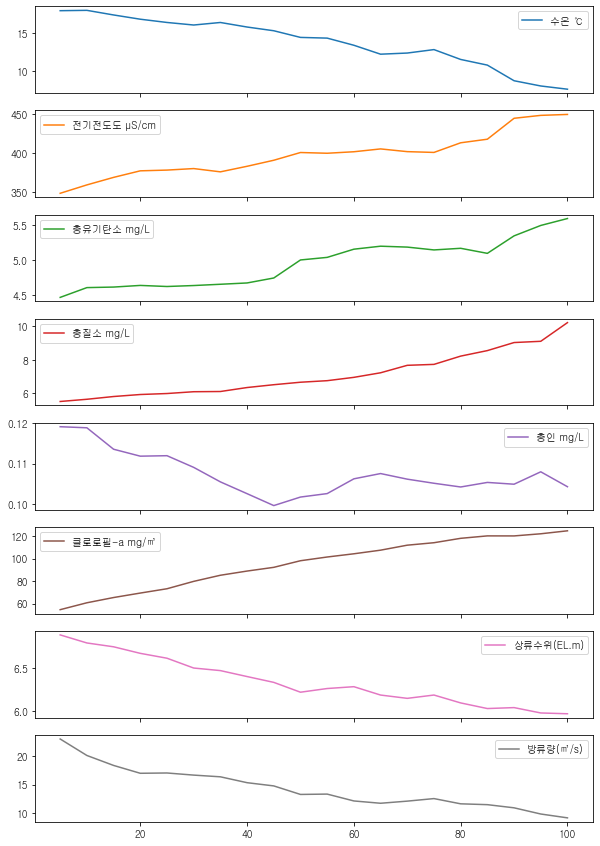

In [106]:
day_mean_df.plot(subplots=True, figsize=(10, 15))